<a href="https://colab.research.google.com/github/ENGCSS/Trabalho_Analise_espacial_de_redes/blob/main/Tb_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# INSTALA AS BIBLIOTECAS NECESSÁRIAS
!pip install osmnx -q
!pip install mapclassify -q

In [58]:
# IMPORTA AS BIBLIOTECAS NECESSÁRIAS
import osmnx as ox                                                            # Biblioteca para análise de redes viárias e geodados
import networkx as nx
import folium                                                                 # Biblioteca para criar mapas interativos
import matplotlib.pyplot as plt                                               # Biblioteca para plotagens gráficas
import geopandas as gpd                                                       # Biblioteca para manipulação de dados geoespaciais
import warnings                                                               # Biblioteca para gerenciar avisos no Python
import base64                                                                 # Biblioteca para codificação e decodificação de dados binários
from shapely.geometry import Point, Polygon, LineString, mapping              # Classes para representar geometrias espaciais
from shapely.ops import transform
from pyproj import Transformer
from matplotlib.lines import Line2D
from matplotlib.colors import rgb2hex
warnings.filterwarnings("ignore")                                             # Ignorar avisos para manter o console limpo

In [20]:
def gerar_poligonos_isocronas(grafo,
                              nodo_central,
                              valores_metrica,
                              metrica="tempo",
                              buffer_arestas=25,
                              buffer_nodos=0,
                              preencher=True
                              ):

    poligonos_isocronas = []

    # Iterar sobre os valores da métrica em ordem decrescente
    for valor in sorted(valores_metrica, reverse=True):
        # Criar um subgrafo com base na métrica escolhida
        subgrafo = nx.ego_graph(grafo, nodo_central, radius=valor, distance=metrica)

        # Criar GeoDataFrame para os nós
        pontos_nodos = [
            Point((dados["x"], dados["y"])) for _, dados in subgrafo.nodes(data=True) if "x" in dados and "y" in dados
        ]
        nodos_gdf = gpd.GeoDataFrame({"id": list(subgrafo.nodes)}, geometry=pontos_nodos).set_index("id")

        # Criar lista de geometrias para as arestas
        linhas_arestas = []
        for nodo_de, nodo_para in subgrafo.edges():
            dados_aresta = grafo.get_edge_data(nodo_de, nodo_para)
            if dados_aresta:  # Verificar se há dados da aresta
                # Obter geometria da aresta ou criar uma linha entre os nós
                geometria_aresta = dados_aresta.get(0, {}).get(
                    "geometry", LineString([nodos_gdf.loc[nodo_de].geometry, nodos_gdf.loc[nodo_para].geometry])
                )
                linhas_arestas.append(geometria_aresta)

        # Criar buffers para nós e arestas
        buffers_nodos = nodos_gdf.buffer(buffer_nodos).geometry
        buffers_arestas = gpd.GeoSeries(linhas_arestas).buffer(buffer_arestas).geometry

        # Combinar todas as geometrias e formar a isócrona
        todas_geometrias = list(buffers_nodos) + list(buffers_arestas)
        nova_isocrona = gpd.GeoSeries(todas_geometrias).unary_union

        # Preencher o polígono se solicitado
        if preencher and isinstance(nova_isocrona, Polygon):
            nova_isocrona = Polygon(nova_isocrona.exterior)                     # Remove buracos internos

        poligonos_isocronas.append(nova_isocrona)

    return poligonos_isocronas

In [3]:
# Excluir o diretório existente no Jupyter Notebook ou IPython
!rm -rf Trabalho_Analise_espacial_de_redes

# Clonar o repositório novamente
!git clone https://github.com/ENGCSS/Trabalho_Analise_espacial_de_redes.git

Cloning into 'Trabalho_Analise_espacial_de_redes'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 72 (delta 27), reused 37 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 8.22 MiB | 5.57 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [4]:
#DEFINE O CRS DO PROJETO
crs_utm = "EPSG:32723"
crs_geo = "EPSG:4326"                                                          # WGS 84 Latitude/Longitude

<Axes: >

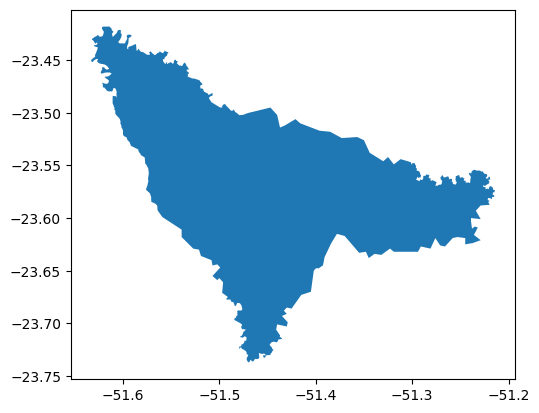

In [5]:
# DEFINI DA CIDADE
cidade = "Apucarana, Brasil"                                            # Define o nome da cidade para ser usado na extração de dados geográficos

# OBTER O POLÍGONO DA CIDADE
pol_cidade = ox.geocode_to_gdf(cidade)                                          # Realiza a geocodificação para obter o polígono da cidade

# CALCULAR O CENTRO DO POLÍGONO
centro = [pol_cidade.geometry.centroid.y.values[0],                             # Coordenada Y do centroide
          pol_cidade.geometry.centroid.x.values[0]]                             # Coordenada X do centroide

# PLOTAR O POLÍGONO DA CIDADE
pol_cidade.plot()

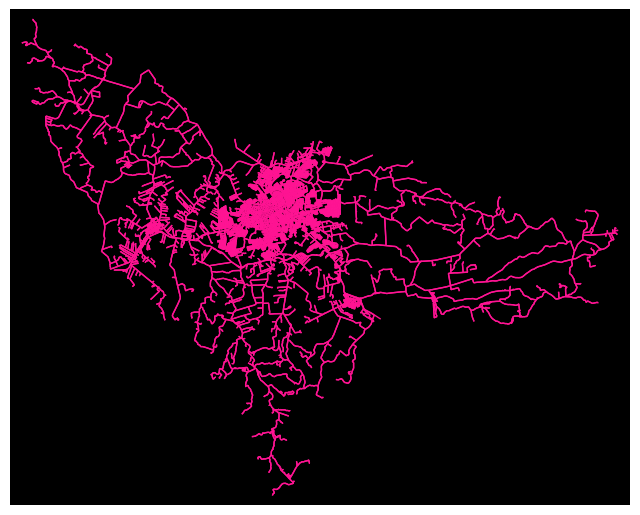

In [7]:
# EXTRAI A REDE VIÁRIA
grafo_rede_viaria_geo = ox.graph_from_place(cidade,
                                        network_type="all"
                                        )

# CONVERSÃO PARA GDF GEO
gdf_nos_geo, gdf_arestas_geo = ox.graph_to_gdfs(grafo_rede_viaria_geo)

# PROJETAR O GRAFO PARA O CRS UTM
grafo_rede_viaria_utm = ox.project_graph(grafo_rede_viaria_geo,
                                         to_crs=crs_utm
                                         )

# CONVERSÃO PARA GDF UTM
gdf_nos_utm, gdf_arestas_utm = ox.graph_to_gdfs(grafo_rede_viaria_utm)

# PLOTAR REDE
fig, ax = ox.plot_graph(grafo_rede_viaria_utm,                                  # Plota o grafo da rede viária
                        bgcolor="black",                                        # Define o fundo do gráfico como preto
                        node_size=0,                                            # Define o tamanho dos nós como 0 (nós não serão visíveis)
                        edge_color="deeppink"                                   # Define a cor das arestas como azul
                        )

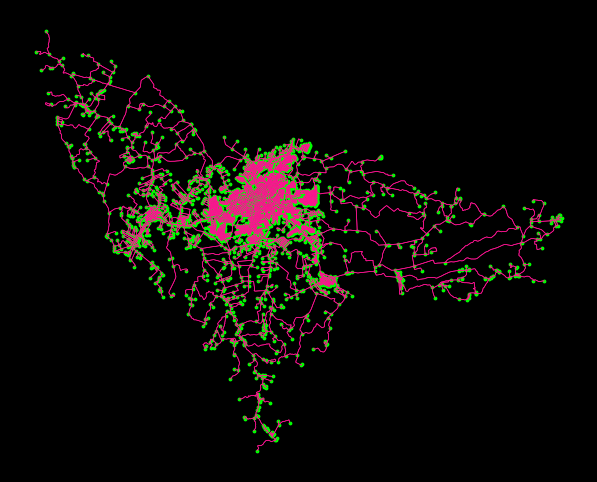

In [8]:
# CRIAÇÃO DA FIGURA E DOS EIXOS
fig, ax = plt.subplots(figsize=(10, 6))

# Alterar o fundo do gráfico para preto
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Plotar o GeoDataFrame das arestas
gdf_arestas_utm.plot(ax=ax,
                 color="deeppink",                                              # Cor das arestas
                 alpha=1,                                                       # Opacidade
                 edgecolor="deeppink",                                          # Cor da borda das arestas
                 linewidth=0.5,                                                 # Espessura das arestas
                 label="Região de Saúde de Irecê"                               # Legenda
                )

# Plotar o GeoDataFrame dos nós
gdf_nos_utm.plot(ax=ax,
             color="lime",                                                      # Cor dos pontos (nós)
             label="Aparelhos de Saúde",                                        # Legenda
             markersize=3                                                       # Tamanho dos pontos
            )

# REMOVER EIXOS E RÓTULOS
ax.set_xticks([])                                                               # Remove os ticks do eixo X
ax.set_yticks([])                                                               # Remove os ticks do eixo Y
ax.set_xticklabels([])                                                          # Remove os rótulos do eixo X
ax.set_yticklabels([])                                                          # Remove os rótulos do eixo Y

# EXIBIR O GRÁFICO
plt.show()

In [9]:
# NÚMERO TOTAL DE NÓS
print("Número total de nós:", len(gdf_nos_utm))                                     # Calcula e exibe o número total de nós no GeoDataFrame
# NÚMERO TOTAL DE ARESTAS
print("Número total de arestas:", len(gdf_arestas_utm))                             # Calcula e exibe o número total de arestas na rede viária

Número total de nós: 6144
Número total de arestas: 16770


In [10]:
# Definir a tag para buscar contornos de edifícios
tags = {"amenity": "hospital"}

# Extraindo contornos
gdf_hospitais_geo = ox.features_from_place(cidade, tags)
gdf_hospitais_utm = gdf_hospitais_geo.to_crs(crs_utm)

print(gdf_hospitais_utm.shape)                                                      # Exibe o número de edifícios encontrados
gdf_hospitais_utm.head()

(1, 4)


,,geometry,amenity,healthcare,name
element,id,,,,
way,375707365,"POLYGON ((-160324.303 7380208.33, -160309.093 ...",hospital,hospital,Hospital da Providência


In [15]:
# Filtrar o hospital de interesse pelo seu identificador único
hospital_id = 375707365
gdf_hospitais_utm = gdf_hospitais_utm.reset_index()                                     # Redefinir o índice para usar o "id" como coluna
gdf_hospital_utm = gdf_hospitais_utm[gdf_hospitais_utm["id"] == hospital_id]

# Verificar se o hospital foi encontrado
if gdf_hospital_utm.empty:
    print("Hospital não encontrado.")
else:
    gdf_hospital_coords = gdf_hospital_utm.geometry.iloc[0]
    print(f"Hospital selecionado: {gdf_hospital_utm['name'].iloc[0]}")

Hospital selecionado: Hospital da Providência


<Axes: >

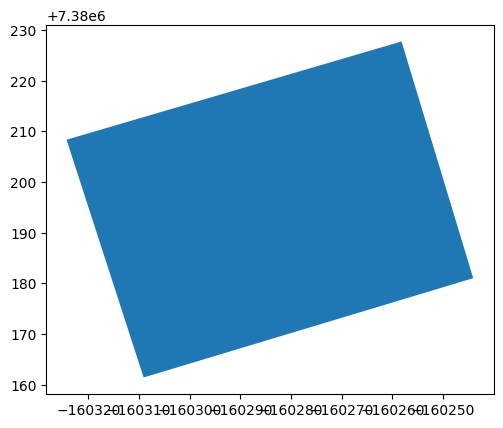

In [16]:
# Visualizar o hospital selecionado
gdf_hospital_utm.plot()

In [17]:
centroide_hospital_utm = gdf_hospital_utm.centroid

nodo_central_utm = ox.distance.nearest_nodes(grafo_rede_viaria_utm,
                                         X=centroide_hospital_utm.x,
                                         Y=centroide_hospital_utm.y
                                         )[0]

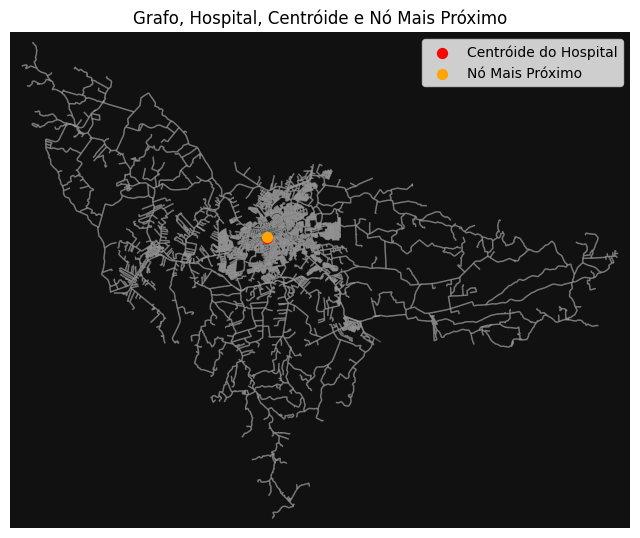

In [19]:
# Plotar o grafo
figura, eixo = ox.plot_graph(grafo_rede_viaria_utm,
                             show=False,
                             close=False,
                             edge_color="#999999",
                             edge_alpha=0.5,
                             node_size=0
                             )

# Adicionar o polígono do hospital ao mapa
gdf_hospital_utm.plot(ax=eixo,
                  facecolor="lightblue",
                  edgecolor="blue",
                  alpha=0.7,
                  zorder=2,
                  label="Hospital"
                  )

# Adicionar o centróide do hospital
plt.scatter(centroide_hospital_utm.x,
            centroide_hospital_utm.y,
            c="red",
            s=50,
            zorder=3,
            label="Centróide do Hospital"
            )

# Adicionar o nó mais próximo
nodo_x = grafo_rede_viaria_utm.nodes[nodo_central_utm]["x"]
nodo_y = grafo_rede_viaria_utm.nodes[nodo_central_utm]["y"]
plt.scatter(nodo_x,
            nodo_y,
            c="orange",
            s=50,
            zorder=4,
            label="Nó Mais Próximo"
            )

# Configurações de legenda e título
plt.legend()
plt.title("Grafo, Hospital, Centróide e Nó Mais Próximo")
plt.show()

In [62]:
velocidade_deslocamento = 4                                                     # Velocidade de caminhada em km/h
tempos_viagem = [5, 15, 30, 45]                                                 # Tempos de viagem em minutos

poligonos_tempo = gerar_poligonos_isocronas(grafo=grafo_rede_viaria_utm,
                                            nodo_central=nodo_central_utm,
                                            valores_metrica=tempos_viagem,
                                            metrica="tempo_viagem",
                                            buffer_nodos=5,
                                            preencher=True
                                            )

gdf_isocronas_tempo = gpd.GeoDataFrame(geometry=poligonos_tempo)
gdf_isocronas_tempo = gdf_isocronas_tempo.set_crs(crs_utm)

for i, poligono in enumerate(poligonos_tempo):
    print(f"Isócrona para tempo ≤ {tempos_viagem[i]} minutos:", poligono)

Isócrona para tempo ≤ 5 minutos: POLYGON ((-164277.05599086557 7370347.460821175, -164272.96740952297 7370362.89124159, -164272.2559441206 7370365.141432523, -164271.3354685696 7370367.314510297, -164270.21418547383 7370369.391110036, -164268.9020868871 7370371.352726602, -164267.410865271 7370373.181879506, -164265.75380930043 7370374.862268677, -164263.94568544457 7370376.378919716, -164262.002606379 7370377.718317342, -164247.08986345914 7370386.991226573, -164244.9118516523 7370388.199438304, -164242.6244273528 7370389.184933659, -164240.2502946597 7370389.937930985, -164206.50616794443 7370398.816999201, -164178.5040865832 7370409.539786522, -164156.21978175928 7370422.35050313, -164125.23528207117 7370445.264947302, -164111.25721012353 7370474.162428588, -164103.5082496967 7370531.121160556, -164104.36089779544 7370545.41109916, -164109.9391277833 7370547.291546076, -164112.13686835737 7370548.149907414, -164114.2439022976 7370549.211630443, -164122.46757381677 7370553.854509554,

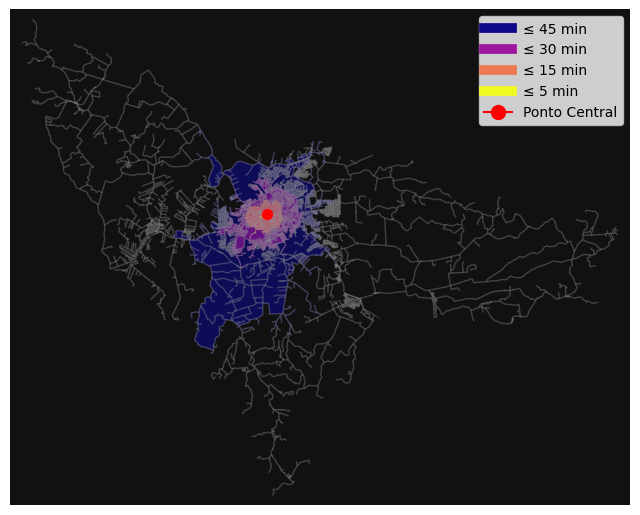

In [63]:
# Definir cores das isócronas
cores_isocronas = ox.plot.get_colors(n=len(tempos_viagem),
                                     cmap="plasma",
                                     start=0
                                     )

# Plotar a rede viária e os polígonos das isócronas
figura, eixo = ox.plot_graph(grafo_rede_viaria_utm,
                             show=False,
                             close=False,
                             edge_color="#999999",
                             edge_alpha=0.2,
                             node_size=0
                             )

gdf_isocronas_tempo.plot(ax=eixo,
                         color=cores_isocronas,
                         ec="none",
                         alpha=0.6,
                         zorder=-1
                         )

# Adicionar o ponto central ao gráfico
nodo_central_x, nodo_central_y = grafo_rede_viaria_utm.nodes[nodo_central_utm]["x"], grafo_rede_viaria_utm.nodes[nodo_central_utm]["y"]

eixo.scatter(nodo_central_x,
             nodo_central_y,
             c="red",
             s=50,
             zorder=10,
             label="Ponto Central"
             )

# Criar a legenda com cores associadas aos tempos de viagem
legenda_tempos = [Line2D([0], [0],
                         color=cores_isocronas[i],
                         lw=7,
                         label=f"≤ {tempo} min"
                         )for i, tempo in enumerate(sorted(tempos_viagem,reverse=True))]

# Adicionar o ponto central à legenda
legenda_ponto_central = Line2D([0], [0],
                               marker="o",
                               color="red",
                               label="Ponto Central",
                               markersize=10
                               )

# Adicionar a legenda ao gráfico
plt.legend(handles=legenda_tempos + [legenda_ponto_central],
           loc="upper right"
           )

# Mostrar o gráfico
plt.show()

In [64]:
# REPROJETAR PARA CRS GEOGRÁFICO

# REPROJETAR AS ISÓCRONAS PARA O SISTEMA DE COORDENADAS GEOGRÁFICO
gdf_isocronas_tempo_geo = gdf_isocronas_tempo.to_crs(crs_geo)

# CALCULAR O CENTROIDE DO HOSPITAL APÓS REPROJETAR
centroide_hospital = gdf_hospital_utm.to_crs(crs_geo).centroid

# ARMAZENAR O CENTROIDE EM FORMATO DE LISTA [LATITUDE, LONGITUDE]
centro2 = [centroide_hospital.y, centroide_hospital.x]

# CONFIGURAR O MAPA BASE USANDO FOLIUM
mapa = folium.Map(location=centro2,
                  zoom_start=13)

# ADICIONAR AS ISÓCRONAS AO MAPA
for i, poligono in enumerate(gdf_isocronas_tempo_geo.geometry):
    if poligono.is_valid:
        folium.GeoJson(mapping(poligono),
                       style_function=lambda x,
                       cor=cores_isocronas[i]: {"fillColor": cor,
                                                "color": cor,
                                                "weight": 2,
                                                "fillOpacity": 0.5,
                                                },
                       name=f"Isócrona {tempos_viagem[i]} min",
                       ).add_to(mapa)

# ADICIONAR O PONTO CENTRAL AO MAPA
folium.Marker(location=centro2,
              popup=gdf_hospital_utm['name'].iloc[0],
              icon=folium.Icon(color="red",
                               icon="hospital-symbol",
                               prefix="fa"
                               )
              ).add_to(mapa)



# Adicionar a legenda como um popup fixo no mapa
folium.Popup(legenda_html, max_width=300).add_to(mapa)

# Adicionar a legenda como um popup fixo no mapa
folium.Marker([centro2[0] + 0.01, centro2[1] + 0.01],
              icon=folium.DivIcon(html=legenda_html)
             ).add_to(mapa)


# ADICIONAR CAMADA DE CONTROLE
folium.LayerControl().add_to(mapa)

# EXIBIR O MAPA
mapa

In [65]:
# REPROJETAR PARA CRS GEOGRÁFICO
gdf_isocronas_tempo_geo = gdf_isocronas_tempo.to_crs(crs_geo)                   # Reprojeta as isócronas para o sistema de coordenadas geográficas

# CALCULAR O CENTROIDE DO HOSPITAL
centroide_hospital = gdf_hospital_utm.to_crs(crs_geo).centroid                  # Calcula o centroide do hospital após reprojeção para o sistema geográfico
centro2 = [centroide_hospital.y, centroide_hospital.x]                          # Extrai as coordenadas do centroide (Y e X)


# EXEMPLO DE TEMPOS DE VIAGEM (EM MINUTOS) E CORES CORRESPONDENTES
n_isocronas = len(tempos_viagem)

# GERAR CORES AUTOMATICAMENTE (EM HEX)
cmap = plt.cm.get_cmap("viridis", n_isocronas)                                  # Paleta de cores "viridis"
cores_isocronas = [rgb2hex(cmap(i / (n_isocronas - 1))) for i in range(n_isocronas)]

# CONFIGURAR O MAPA BASE USANDO FOLIUM
mapa = folium.Map(location=[-23.55, -51.46], zoom_start=13)                     # Coordenadas aproximadas para Apucarana

# ADICIONAR AS ISÓCRONAS AO MAPA
for i, (tempo, poligono) in enumerate(zip(tempos_viagem, gdf_isocronas_tempo_geo.geometry)):
    if poligono.is_valid:
        folium.GeoJson(mapping(poligono),
                       style_function=lambda x,
                       cor=cores_isocronas[i]: {"fillColor": cor,
                                                              "color": cor,
                                                              "weight": 2,
                                                              "fillOpacity": 0.5,
                                                              },
                                               name=f"Isócrona {tempo} min",
                       ).add_to(mapa)

# ADICIONAR O PONTO CENTRAL AO MAPA
folium.Marker(location=centro2,
              popup=gdf_hospital_utm['name'].iloc[0],
              icon=folium.Icon(color="red",
                               icon="hospital-symbol",
                               prefix="fa"
                               ),
              ).add_to(mapa)

# ADICIONAR A LEGENDA PERSONALIZADA
legend_html = f"""
<div style="position: fixed;
            bottom: 30px; left: 30px; width: 250px; height: {40 * n_isocronas}px;
            background-color: white; z-index: 1000; border:2px solid grey; padding: 10px;">
    <h4 style="margin-top: 0">Legenda - Isócronas</h4>
"""
# USAR AS CORES E TEMPOS NA ORDEM CORRETA
for tempo, cor in zip(tempos_viagem, cores_isocronas[::-1]):                    # INVERSÃO APLICADA
    legend_html += f"""
    <div style="display: flex; align-items: center; margin-bottom: 5px;">
        <div style="width: 20px; height: 20px; background: {cor}; margin-right: 10px;"></div>
        <span>{tempo} minutos</span>
    </div>
    """
legend_html += "</div>"

mapa.get_root().html.add_child(folium.Element(legend_html))

# ADICIONAR CAMADA DE CONTROLE
folium.LayerControl().add_to(mapa)

# EXIBIR O MAPA
mapa

In [ ]:
# Caminho para o arquivo GeoPackage
geopackage_path = '/content/Trabalho_Analise_espacial_de_redes/DATA/DADOS.gpkg'

# Ler a camada específica do GeoPackage
gdf_pontos = gpd.read_file(geopackage_path,
                           layer='eq_rs_irece',
                           )

gdf_regiao = gpd.read_file(geopackage_path,
                           layer='rs_irece'
                           )

gdf_irece = gpd.GeoDataFrame(gdf_regiao[gdf_regiao["nome_mun"] == "Irecê"],
                             crs=gdf_regiao.crs
                             )












# CRIAÇÃO DA FIGURA E DOS EIXOS
fig, ax = plt.subplots(figsize=(10, 6))

# PLOTAGEM DO PRIMEIRO GDF
# DEFININDO COR E LEGENDA
gdf_irece.plot(ax=ax,
                color="black",
                alpha=1,
                edgecolor="black",
                linewidth=0.5,
                label="Região de Saúde de Irecê"
                )

# PLOTAGEM DO SEGUNDO GDF
# DEFININDO COR E LEGENDA
gdf_pontos.plot(ax=ax,
                color="orangered",
                markersize=20,
                label="Aparelhos de Saúde"
                )

# CONFIGURAÇÃO DE TÍTULOS E LEGENDA
plt.title("Principais Aparelhos da RS de Irecê", fontsize=16)                   # TÍTULO DO GRÁFICO
plt.xlabel("Longitude")                                                         # RÓTULO DO EIXO X
plt.ylabel("Latitude")                                                          # RÓTULO DO EIXO Y
plt.legend(loc=(0.42,0.05))                                                     # ADICIONA A LEGENDA AO GRÁFICO

# EXIBIÇÃO DO MAPA
plt.show()
















# Carregar o geodataframe de pontos
pts = gdf_pontos.to_crs(epsg=4326)



# MAPA CENTRALIZADO
mapa_01 = folium.Map(location=centro,                                           # Define o centro do mapa
                     zoom_start=12,                                             # Define o nível inicial de zoom
                     #tiles='CartoDB positron',                                 # Define o tipo de mapa de fundo
                     control_scale = True,                                      # Habilita a escala do mapa
                     )

geo_json = poligono_cidade.to_json()                                            # Converte o polígono do bairro para o formato GeoJSON

# ADICIONA O POLÍGONO DA ÁREA AO MAPA
folium.GeoJson(geo_json,                                                        # Adiciona o polígono representando a área do bairro
               name="CentroNit",                                                # Nome da camada no controle
               style_function=lambda x: {'fillColor': 'lime',                   # Cor de preenchimento
                                         'color': 'magenta',                    # Cor da borda
                                         'weight': 2.5,                         # Espessura da borda
                                         'fillOpacity': 0.3                     # Opacidade do preenchimento
                                         }
               ).add_to(mapa_01)

dir = '/content/Trabalho_Analise_espacial_de_redes/DATA/IMAGENS/'

# ADICIONAR PARADAS DE ÔNIBUS AO MAPA
for idx, row in pts.iterrows():

    dir_imagem = dir + row['NM_ARQ']

    #Carrega a imagem que será usada no popup do marcador
    with open(dir_imagem, "rb") as imagem_arquivo:
        imagem_codificada = base64.b64encode(imagem_arquivo.read()).decode('utf-8')

    #Cria o cod. html com o conteúdo do popup
    html_popup = f"""
    <!DOCTYPE html>
    <html lang="pt-BR">
    <head>
        <meta charset="UTF-8">
        <title>Detalhes do Ponto de Saúde</title>
    </head>
    <body>
        <h4><b>{row['NM_PT']}</b></h4>
        <p><b>{row['CAT']}</b></p>
        <img src="data:image/jpg;base64,{imagem_codificada}" alt="Imagem do Ponto de Saúde" style="max-width:300px;">
        <p>Serviços: {row['SERV']}</p>
    </body>
    </html>
    """
    #Cria o marcador do ponto
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],
        popup=folium.Popup(html_popup, max_width=450),
        tooltip=row['NM_PT'],
        icon=folium.Icon(color=row['COR'],
                         icon_color='k',
                         icon=row['ICO'],
                         prefix='fa'
                         ),
        draggable=True
    ).add_to(mapa_01)


# ADICIONAR ARESTAS COMO GEOJSON AO MAPA
arestas_layer = folium.GeoJson(
    gdf_arestas_utm,
    name="Rede de Arestas",
    style_function=lambda x: {'fillColor': "#FF1493",
                              'color': "#FF1493",
                              'weight': 2,
                              'fillOpacity': 1
                              }
    ).add_to(mapa_01)                                                               # Adiciona a camada de arestas ao mapa

# ADICIONAR NÓS COMO CIRCLEMARKER AO MAPA
nos_layer = folium.FeatureGroup(name="Rede de Nós")                             # Cria um grupo para os nós

for _, row in gdf_nos_utm.iterrows():
    if row.geometry.geom_type == "Point":                                       # Verifica se a geometria do nó é um ponto
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],                          # Coordenadas do nó
            radius=3,                                                           # Raio do marcador
            color="cyan",                                                       # Cor da borda do marcador
            fill=True,                                                          # Ativa o preenchimento do marcador
            fill_color="cyan",                                                  # Cor de preenchimento
            fill_opacity=1,                                                     # Define a opacidade do preenchimento
            popup=f"Nó: {row.name}"                                             # Adiciona um popup com o nome do nó
        ).add_to(nos_layer)                                                     # Adiciona o marcador ao grupo de nós

nos_layer.add_to(mapa_01)                                                       # Adiciona o grupo de nós ao mapa

# ADICIONAR DIFERENTES CAMADAS DE MAPAS
folium.TileLayer('Stamen Terrain', attr="Map tiles by Stamen Design", name="Stamen Terrain").add_to(mapa_01)      # Camada de terreno
folium.TileLayer('Stamen Toner', attr="Map tiles by Stamen Design", name="Stamen Toner").add_to(mapa_01)          # Camada de alto contraste
folium.TileLayer('CartoDB positron', attr="Map tiles by CartoDB", name="CartoDB positron").add_to(mapa_01)        # Camada clara
folium.TileLayer('CartoDB dark_matter', attr="Map tiles by CartoDB", name="CartoDB dark_matter").add_to(mapa_01)  # Camada escura

# ADICIONAR CONTROLE DE CAMADAS
folium.LayerControl().add_to(mapa_01)                                           # Adiciona o controle de camadas ao mapa

# EXIBIR MAPA
mapa_01                                                                         # Renderiza o mapa interativo com o polígono da área